In [35]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [20]:
df = pd.DataFrame(region_predict.K2_bw_ts, columns=['bw','hour', 'lon','lat'])

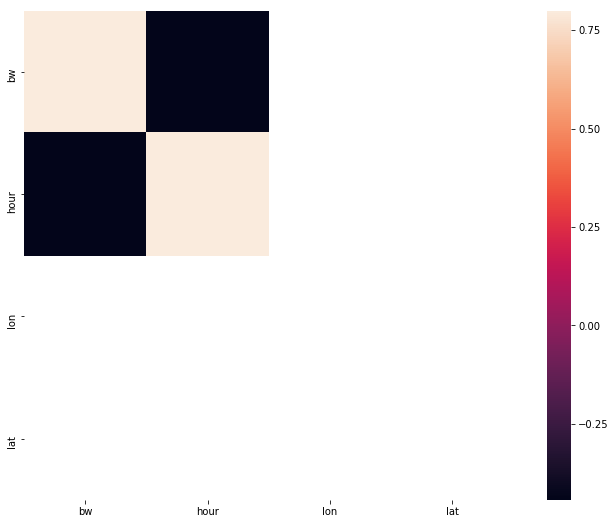

In [22]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

strategy use yesterday's hour:min, mre: 7.0%


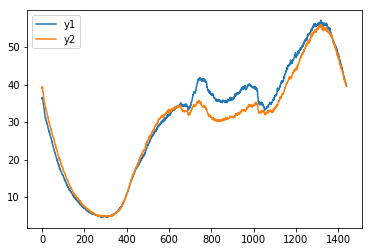

In [47]:
y1 = region_predict.K2_bw_ts[1440:2880][:,0]
y2 = region_predict.K2_bw_ts[2880:1440*3][:,0]
# strategy 
mre = np.mean(np.abs(y2 - y1)/ y1)
print("strategy use yesterday's hour:min, mre: %.1f%%" %(100 * mre))

plt.plot(y1)
plt.plot(y2)
plt.legend(['y1','y2'])

In [403]:
from region_predict import *

In [402]:
reload(region_predict)

<module 'region_predict' from 'region_predict.py'>

In [409]:
    n = np.random.randint(N_data, size=1)
    test_ts = np.array(range(n_test + lst_t[-1] + n_steps)) + n_start

In [406]:
len(K2_bw_ts), K2_bw_ts[0].shape

(31, (18720, 4))

In [413]:
main(n_future, False, test_ts, n)

INFO:tensorflow:Restoring parameters from ./region_predict_model_20


NameError: global name 'X_test' is not defined

In [412]:
test_ts.shape

(1490,)

In [414]:
X_test = time_series(n, test_ts[i:i+n_steps]).reshape(1, n_steps, -1)

ValueError: cannot reshape array of size 4 into shape (1,20,newaxis)

In [415]:
test_ts[i:i+n_steps]

array([10952, 10953, 10954, 10955, 10956, 10957, 10958, 10959, 10960,
       10961, 10962, 10963, 10964, 10965, 10966, 10967, 10968, 10969,
       10970, 10971])

In [417]:
i,n,n_steps

(0, array([23]), 20)

In [419]:
time_series(n, test_ts[i:i+n_steps]).shape

(1, 4)

In [421]:
n, test_ts[i:i+n_steps].shape

(array([23]), (20,))

In [425]:
time_series(n, test_ts[i:i+n_steps].reshape(1, -1)).shape

(1, 20, 4)

In [429]:
def main(n_future, training=True, test_ts = None, n = None):
    reset_graph()

    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

    cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
    # loss = tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, outputs)))))
    loss = tf.reduce_mean(tf.divide(tf.abs(outputs - y), y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    saver = tf.train.Saver()
    fname = '%s_%s' %(fname_model, n_future)

    with tf.Session() as sess:
        if training:
            if run_on:
                saver.restore(sess, fname)
            else:
                init = tf.global_variables_initializer()
                init.run()
            for iteration in range(n_iterations):
                X_batch, y_batch = next_batch(N_train, n_future)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
                if iteration % 100 == 0:
                    mre = loss.eval(feed_dict={X: X_batch, y: y_batch})
                    # mean relative error
                    print(iteration, "\tmre: %.1f%%" %(100. * mre))
            saver.save(sess, fname)
            return mre
        else:
            saver.restore(sess, fname)
            Y_pred = []
            for i in range(n_test):
                X_test = time_series(n, test_ts[i:i+n_steps].reshape(1, -1))
                y_pred = sess.run(outputs, feed_dict={X: X_test})
                Y_pred.append(y_pred[0, -1, 0])
            return Y_pred

In [431]:
res = main(n_future, False, test_ts, n)

INFO:tensorflow:Restoring parameters from ./region_predict_model_20


In [443]:
test_ts[:n_steps].shape, time_series(n, test_ts[:n_steps]).shape

((20,), (1, 4))

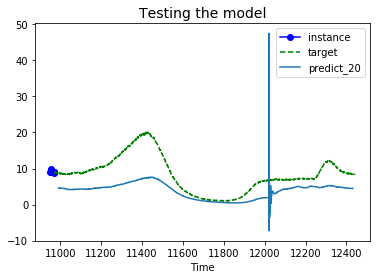

In [458]:
show_predict(n, test_ts, Ys, lst_t)

In [456]:
n, test_ts[:n_steps], time_series(n, test_ts[:n_steps].reshape(1,-1))[0,:,0]

(array([23]),
 array([10952, 10953, 10954, 10955, 10956, 10957, 10958, 10959, 10960,
        10961, 10962, 10963, 10964, 10965, 10966, 10967, 10968, 10969,
        10970, 10971]),
 array([9.138052 , 9.5048055, 9.5286095, 9.8576815, 9.0886631, 9.1676123,
        8.9334036, 9.0478377, 9.1320669, 8.9982871, 9.1730606, 9.0952499,
        8.9701062, 9.0757579, 9.0649218, 9.02737  , 9.0489399, 9.1335761,
        8.9565575, 8.8421069]))

In [457]:
def show_predict(n, test_ts, Ys, lst_t):
    plt.title("Testing the model", fontsize=14)
    try:
        plt.plot(
            test_ts[:n_steps],
            time_series(n, test_ts[:n_steps].reshape(1,-1))[0,:,0],
            "bo-",
            label="instance")
        plt.plot(
            test_ts[n_steps:],
            time_series(n, test_ts[n_steps:].reshape(1,-1))[0,:,0],
            "g--",
            label="target")
        for i, n_future in enumerate(lst_t):
            plt.plot(
                test_ts[n_steps + n_future:n_steps + n_future + n_test],
                Ys[i],
                label="predict_%s" %n_future)
    except:
        print(n, n_steps)
        raise
    plt.legend(loc="best")
    plt.xlabel("Time")
    plt.show()